In [47]:
# libraries
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

from IPython.display import display
from numpy import where
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.svm import OneClassSVM
import operator

In [48]:
# Constants
TRAINING_YEAR = 2015
TESTING_YEAR = 2017
ATTRIBUTE_SIZE = 8

In [72]:
# We might not need player_data.csv and players.csv since they are personal information that we can not make use of
salary_20 = pd.read_csv("salary_0020.csv")
salary_17 = pd.read_csv("salary_1718.csv")
stats = pd.read_csv("1950/seasons_stats.csv")
stats = stats.drop(stats.columns[0], axis=1)
pd.set_option('display.max_columns', None)


# Append salary to the dataframe
# Use the following attributes to fit models
# age, G, GS, MP, PER, TS, FTr, ORB%, DRB%, TRB%, AST%  STL%  BLK% TOV%  USG%, OWS  DWS, WS  WS/48, VORP, OBPM  DBPM  BPM and everything afterwards

team_names = {
    "Atlanta Hawks":"ATL",
    "Boston Celtics":"BOS",
    "Brooklyn Nets":"BKN",
    "Charlotte Hornets":"CHA",
    "Charlotte Bobcats":"CHB",
    "Chicago Bulls":"CHI",
    "Cleveland Cavaliers":"CLE",
    "Dallas Mavericks":"DAL",
    "Denver Nuggets":"DEN",
    "Detroit Pistons":"DET",
    "Golden State Warriors":"GSW",
    "Houston Rockets":"HOU",
    "Indiana Pacers":"IND",
    "LA Clippers":"LAC",
    "Los Angeles Clippers": "LAC",
    "Los Angeles Lakers":"LAL",
    "Memphis Grizzlies":"MEM",
    "Miami Heat":"MIA",
    "Milwaukee Bucks":"MIL",
    "Minnesota Timberwolves":"MIN",
    "New Orleans Pelicans":"NOP",
    "New York Knicks":"NYK",
    "Oklahoma City Thunder":"OKC",
    "Orlando Magic":"ORL",
    "Philadelphia 76ers":"PHI",
    "Phoenix Suns":"PHX",
    "Portland Trail Blazers":"POR",
    "Sacramento Kings":"SAC",
    "San Antonio Spurs":"SAS",
    "Toronto Raptors":"TOR",
    "Utah Jazz":"UTA",
    "Washington Wizards":"WAS",
    "Seattle SuperSonics":"SEA",
    "Vancouver Grizzlies":"VAN",
    "New Jersey Nets":"NJN",
    "New Orleans Hornets":"NOK",
}

unknowns = [
    'Madrid Real Madrid',
    "null Unknown",
    "NO/Oklahoma City Hornets",
    'Bilbao Basket Bilbao Basket',
    "Fenerbahce Ulker Fenerbahce Ulker",
    "Maccabi Haifa Maccabi Haifa"
]

# Convert team names in 0020 dataset to abbreviations
for i in range(len(salary_20)):
    v = salary_20['team'][i]
    if v in unknowns:
        continue
    salary_20.loc[i,'team'] = team_names[v]

# Remove unknowns
for v in unknowns:
    salary_20 = salary_20[salary_20['team'] != v]

# Only use players from 2000 onward
stats = stats[stats['Year'] >= 2000]


# Add salary to stats dataset based on player, year
merged_00_to_17 = stats.merge(salary_20, left_on=['Year', 'Player', 'Tm'], right_on=['season', 'name', 'team'])

# Drop unused columns that we think are irrelevant from merged dataset
merged_00_to_17 = merged_00_to_17.drop(columns = ['Player', 'Pos', 'Tm', '3PAr', 'blanl', 'blank2', 'rank', 'position', 'team', 'name', 'season'])

# Replace Nan with 0
merged_00_to_17.fillna(0, inplace=True)

# display(salary_20.head(10))

# display(stats.head(10))

# display(merged_00_to_17.head(10))

# display(merged_00_to_17.tail(10))

# Different datasets to see what produces best predictions
# Can either always predict later year or split train, test throughout years

merged_10_to_17 = merged_00_to_17[merged_00_to_17['Year'] >= 2010]

merged_13_to_17 = merged_00_to_17[merged_00_to_17['Year'] >= 2013]

# Using 16 to predict 17

merged_16_17 = merged_00_to_17[merged_00_to_17['Year'] >= 2016]

# Split within year

merged_17 = merged_00_to_17[merged_00_to_17['Year'] >= 2017]



In [103]:
salary_caps = []
for row in merged_10_to_17['Year']:
    if row == 2010:
        salary_caps.append(58040000)
    elif row == 2011:
        salary_caps.append(58044000)
    elif row == 2012:
        salary_caps.append(58044000)
    elif row == 2013:
        salary_caps.append(58679000)
    elif row == 2014:
        salary_caps.append(63065000)
    elif row == 2015:
        salary_caps.append(70000000)
    elif row == 2016:
        salary_caps.append(94143000)
    elif row == 2017:
        salary_caps.append(99093000)

merged_10_to_17['Salary_Cap'] = salary_caps


data = merged_10_to_17.assign(Percent_of_Cap=lambda x: x.salary/x.Salary_Cap )

cap_data = data['Percent_of_Cap'].sort_values()

cap_data = np.asarray(cap_data)

cap_mean = np.mean(cap_data)

print(cap_mean)

cap_std = np.std(cap_data)

print(cap_std)

# print(len(cap_data))


# print("mean to std1", ((cap_mean <= cap_data) & (cap_data < cap_mean + cap_std)).sum())

# print("-std1 to mean", ((cap_mean - cap_std <= cap_data) & (cap_data < cap_mean)).sum())

# print("std1 to std2", ((cap_mean + cap_std <= cap_data) & (cap_data < cap_mean + 2*cap_std)).sum())

# print("-std2 to -std1", ((cap_mean - 2*cap_std <= cap_data) & (cap_data < cap_mean - cap_std)).sum())

# print("std2 to std3", ((cap_mean + 2*cap_std <= cap_data) & (cap_data < cap_mean + 3*cap_std)).sum())

# print("std3 to std4", ((cap_mean + 3*cap_std <= cap_data) & (cap_data < cap_mean + 4*cap_std)).sum())

# print("std4 to std5", ((cap_mean + 4*cap_std <= cap_data) & (cap_data < cap_mean + 5*cap_std)).sum())

# print("std5 to std6", ((cap_mean + 5*cap_std <= cap_data) & (cap_data < cap_mean + 6*cap_std)).sum())

# print("std6 to std7", ((cap_mean + 6*cap_std <= cap_data) & (cap_data < cap_mean + 7*cap_std)).sum())

data.loc[(cap_mean - cap_std <= data['Percent_of_Cap'] ) & (data['Percent_of_Cap']  < cap_mean), 'Salary_Type'] = 'Minimum'
data.loc[(cap_mean <= data['Percent_of_Cap'] ) & (data['Percent_of_Cap']  < cap_mean + cap_std), 'Salary_Type'] = 'Mid-Level'
data.loc[(cap_mean + cap_std <= data['Percent_of_Cap'] ) & (data['Percent_of_Cap']  < cap_mean + 2*cap_std), 'Salary_Type'] = 'Standard'
data.loc[(cap_mean + 2*cap_std <= data['Percent_of_Cap'] ) & (data['Percent_of_Cap']  < cap_mean + 3*cap_std), 'Salary_Type'] = 'Max'
data.loc[(cap_mean + 3*cap_std <= data['Percent_of_Cap'] ) & (data['Percent_of_Cap']  < cap_mean + 4*cap_std), 'Salary_Type'] = 'SuperMax'
data.loc[(cap_mean + 4*cap_std <= data['Percent_of_Cap'] ) & (data['Percent_of_Cap']  < cap_mean + 5*cap_std), 'Salary_Type'] = 'SuperSuperMax'

print(data)

0.06672100194700979
0.07426282903940541
        Year   Age     G    GS      MP   PER    TS%    FTr  ORB%  DRB%  TRB%  \
2841  2010.0  24.0  82.0  75.0  2221.0  10.9  0.576  0.168   3.1   9.9   6.5   
2842  2010.0  24.0  78.0  78.0  2922.0  18.2  0.535  0.260   8.1  18.6  13.3   
2843  2010.0  23.0   8.0   0.0    29.0   2.8  0.273  0.500   7.8  11.3   9.6   
2844  2010.0  31.0  51.0   3.0   456.0   5.9  0.431  0.112   9.2  11.5  10.4   
2845  2010.0  34.0  80.0  80.0  2819.0  15.2  0.601  0.260   2.0   8.8   5.5   
...      ...   ...   ...   ...     ...   ...    ...    ...   ...   ...   ...   
5987  2017.0  28.0  74.0  74.0  2237.0  14.9  0.562  0.125   6.7  15.8  11.3   
5988  2017.0  27.0  51.0   5.0   525.0  13.0  0.508  0.247   9.2  17.0  13.2   
5989  2017.0  20.0  19.0   0.0   108.0   7.3  0.346  0.161  10.8  24.9  17.6   
5990  2017.0  22.0  44.0  18.0   843.0   6.9  0.503  0.181   1.9  14.2   8.0   
5991  2017.0  19.0  38.0  11.0   609.0  17.0  0.547  0.206   7.1  21.9  14.3   


<ipython-input-103-52036a943faf>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_10_to_17['Salary_Cap'] = salary_caps


Visualize correlation using Heatmap

Pairplot with MP

<AxesSubplot:>

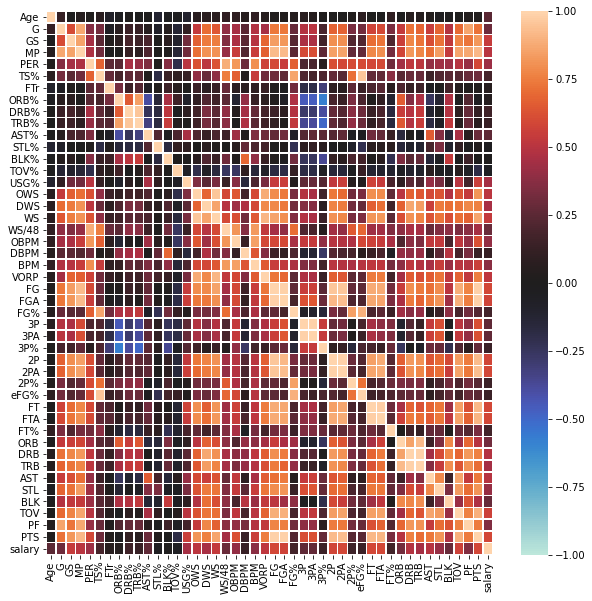

In [54]:
# Filter out some outliers in order to make better predictions
data = merged_00_to_17[merged_00_to_17['Year'] == TRAINING_YEAR]
data = data.drop(['Year'], axis=1)
# heatmap for correlation
fig, ax = plt.subplots(figsize=(10, 10))

sb.heatmap(data.corr(), vmin=-1, vmax=1, center= 0, linewidths=.5, xticklabels=True, yticklabels=True)

# # Max is usually calculated by Q3 + 1.5 * IQR, where IQR = Q3 - Q1
# q3, q1 = np.quantile(data['salary'], [0.75, 0.25])
# local_max = q3 + 1.5 * (q3 - q1)
# print(local_max)
# data = data.reset_index(drop=True)
# sb.boxplot(data['salary'])

# # Get rid of outliers
# data = data[data['salary'] <= local_max]

In [57]:
# Only need the salary column, and take out the correlation with salary itself
correlation = abs(data.corr()['salary'][:-1])

# Get the sorted index of correlation
attribute_rank = np.argsort(correlation)

# Get the most relevant attributes
relevant_attributes = attribute_rank.index[attribute_rank[-ATTRIBUTE_SIZE:]]
print(relevant_attributes)

df_salary = data.copy()
# df_salary = pd.DataFrame(preprocessing.OrdinalEncoder().fit_transform(df_salary), columns=df_salary.columns)
# # OrdinalEncoder will skip numerical values. LabelEncoder also works as they share the same functionality.
# display(df_salary[relevant_attributes])


Index(['TOV', 'FGA', '2P', 'FT', 'FTA', '2PA', 'FG', 'PTS'], dtype='object')


In [59]:
salary_train, salary_test = train_test_split(df_salary, test_size=0.2)
X_salary_train, y_salary_train = salary_train[['PTS', 'FT', '2P', 'FG', 'WS', 'GS', 'TRB', 'TOV', 'AST']], salary_train['salary']
X_salary_test, y_salary_test = salary_test[['PTS', 'FT', '2P', 'FG', 'WS', 'GS', 'TRB', 'TOV', 'AST']], salary_test['salary']
print(X_salary_train)

         PTS     FT     2P     FG    WS    GS    TRB    TOV    AST
4959  1164.0  193.0  355.0  442.0   4.8  63.0  430.0  115.0  124.0
4933   640.0  132.0  254.0  254.0   4.8  17.0  396.0   77.0   71.0
5131   523.0   82.0   84.0  175.0   2.9  38.0  222.0   90.0  208.0
4923   169.0   21.0   74.0   74.0   1.6   8.0  191.0   23.0   16.0
4829   264.0   30.0   48.0   94.0   2.1  19.0  115.0   11.0   47.0
...      ...    ...    ...    ...   ...   ...    ...    ...    ...
5025   286.0   37.0  114.0  121.0   1.3   6.0  207.0   35.0   46.0
4941  1001.0  123.0  439.0  439.0   8.6  82.0  717.0  100.0   97.0
5099   201.0   22.0   25.0   68.0   1.2   3.0   80.0   47.0  104.0
4825   274.0   50.0  112.0  112.0   2.2  27.0  241.0   29.0   34.0
4988  1743.0  375.0  504.0  624.0  10.4  69.0  416.0  272.0  511.0

[329 rows x 9 columns]
